In [78]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [79]:
def process_image(image_path, output_txt):
    # Open image and convert to grayscale
    img = Image.open(image_path).convert("L")
    
    # Resize to 512x512 if not already
    img = img.resize((512, 512))
    
    # Display the grayscale image
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.show()
    
    # Convert image to numpy array
    pixel_data = np.array(img)
    
    # Save pixel values to text file
    with open(output_txt, "w") as f:
        for row in pixel_data:
            for pixel in row:
                f.write(f"{pixel}\n")
    
    print(f"Pixel data saved to {output_txt}")
    return pixel_data



def normalize_and_display(final_result, window_size):

    
    normalized_data = final_result / window_size**2
    normalized_data = np.clip(normalized_data, 0, 255)
    normalized_image = normalized_data.astype(np.uint8)
    

    plt.imshow(normalized_image, cmap="gray")
    plt.axis("off")  
    plt.show()
    
    return normalized_image

def compute_integral_image(img_array):
    """Computes the integral image of the given grayscale image array."""
    return np.cumsum(np.cumsum(img_array, axis=0), axis=1)



def read_print_fpga(input_txt,wid,hei,radius):

    window = 2*radius+1
    width = wid-(window)+1
    heigth = hei-window+1
    # Read pixel values from file
    with open(input_txt, "r") as f:
        pixel_values = [int(line.strip()) for line in f]

    # Convert to numpy array and reshape to given dimensions
    pixel_data = np.array(pixel_values, dtype=np.uint32).reshape((heigth, width))

    # Display the grayscale image
    baska = (pixel_data / window**2).astype(np.uint8)
    plt.imshow(baska, cmap="gray")
    plt.axis("off")
    plt.show()
    return baska

def boxfilter(imSrc, r):

    hei, wid = imSrc.shape
    imDst = np.zeros_like(imSrc, dtype=np.int32)

    # Cumulative sum over the Y axis
    imCum = np.cumsum(imSrc, axis=0)

    # Difference over the Y axis
    imDst[:r+1, :] = imCum[r:2*r+1, :]
    imDst[r+1:hei-r, :] = imCum[2*r+1:hei, :] - imCum[:hei-2*r-1, :]
    imDst[hei-r:, :] = (imCum[hei-1, :][None, :] - imCum[hei-2*r-1:hei-r-1, :])

    # Cumulative sum over the X axis
    imCum = np.cumsum(imDst, axis=1)

    # Difference over the X axis
    imDst[:, :r+1] = imCum[:, r:2*r+1]
    imDst[:, r+1:wid-r] = imCum[:, 2*r+1:wid] - imCum[:, :wid-2*r-1]
    imDst[:, wid-r:] = (imCum[:, wid-1][:, None] - imCum[:, wid-2*r-1:wid-r-1])

    return imDst





********** ORIGINAL IMAGE ******************



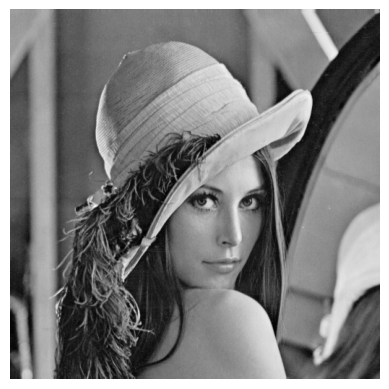

Pixel data saved to output_pixels.txt


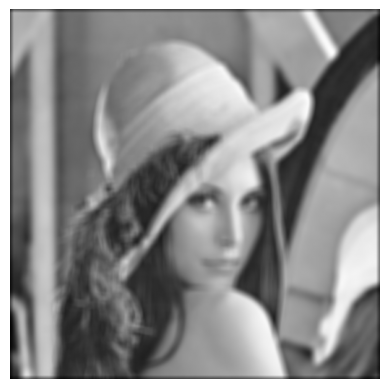

********** INTEGRAL IMAGE ALGO IN PYTHON ******************



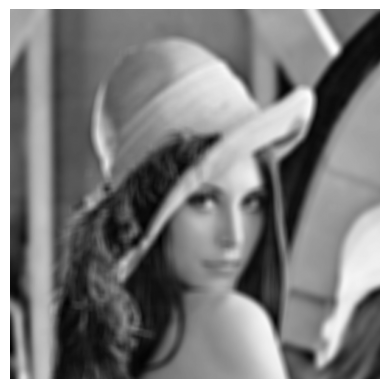

In [80]:


print("********** ORIGINAL IMAGE ******************\n")
img = process_image("lenna.png", "output_pixels.txt")

window_size=11

hei, wei = img.shape

yar = np.zeros((hei, wei))
temp = np.zeros((hei, wei))
box = np.zeros((hei,wei))

r = int((window_size-1)/2)
box = boxfilter(img,r)

##box_image = (box / window_size**2).astype(np.uint8)
plt.imshow(box, cmap="gray")

plt.axis("off")

plt.show()


yar[:window_size-1, :] = compute_integral_image(image[:window_size-1, :])


for i in range(hei - window_size + 1):
    temp = compute_integral_image(img[i:, :])
    yar[i+window_size-1, :] = temp[window_size-1, :] 


final_result = np.zeros((hei-window_size+1,wei-window_size+1))
sub_size_hei,sub_size_wei = final_result.shape

for row in range(sub_size_hei):  # Iterate over each row in `yar`
    for col in range(sub_size_wei):  # Iterate over each column
            
            if col == 0:
                 final_result[row,col] = yar[row+window_size-1, window_size-1]
            else:
                final_result[row, col] = yar[row+window_size-1, col+window_size-1] - yar[row+window_size-1, col-1]





print("********** INTEGRAL IMAGE ALGO IN PYTHON ******************\n")           

normalized_img = normalize_and_display(final_result,window_size)

##print("********** FPGA SIMULATION RESULT ************************ \n")
##input_txt = "guided_filter.sim/sim_1/behav/xsim/yes.txt"
##fpga_data = read_print_fpga(input_txt, 512,512,10)

In [86]:


input_txt = "guided_filter.sim/sim_1/behav/xsim/yes.txt"
fpga_data = read_print_fpga(input_txt, 512,512,21)

ValueError: cannot reshape array of size 0 into shape (470,470)

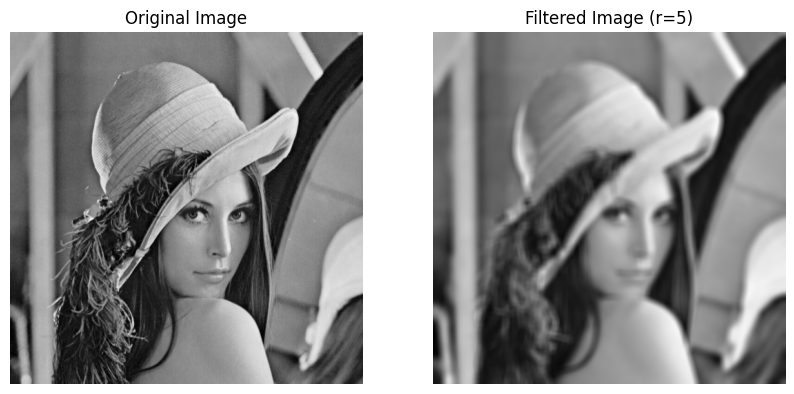

In [82]:

# Load the image (grayscale)
image = cv2.imread('lenna.png', cv2.IMREAD_GRAYSCALE)
##image_normalized = image.astype(np.float32) / 255.0
# Apply the box filter with a radius of 5
radius = 5
N_vec = np.ones((512,512))
N_normal = boxfilter(N_vec,radius)
filtered_image = boxfilter(image, radius) /N_normal

# Display the original and filtered images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(filtered_image, cmap='gray')
plt.title(f"Filtered Image (r={radius})")
plt.axis('off')

plt.show()


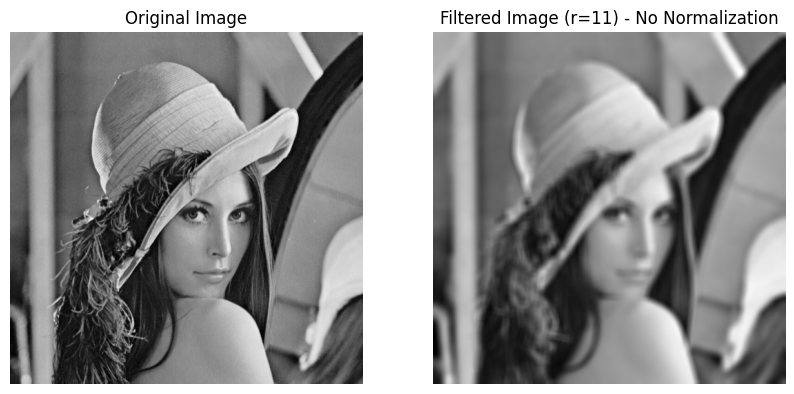

Sample of box filter output matrix (raw sum values):
[[20259. 20311. 20291. 20326. 20321.]
 [20266. 20317. 20295. 20328. 20320.]
 [20238. 20281. 20260. 20292. 20288.]
 [20215. 20251. 20230. 20264. 20261.]
 [20175. 20205. 20187. 20221. 20216.]]


In [83]:
import cv2
import numpy as np
import matplotlib.pyplot as plt  

def box_filter(image, kernel_size):
    """
    Applies an unnormalized box filter to the given image.
    :param image: Input grayscale or color image (NumPy array)
    :param kernel_size: Size of the box filter kernel (e.g., 3, 5, 7, etc.)
    :return: Filtered image (Sum of pixel values in the window)
    """
    kernel = np.ones((kernel_size, kernel_size), dtype=np.float32)  # No normalization
    image = image.astype(np.float32)  # Convert image to float32 to prevent overflow
    boxy = cv2.filter2D(image, -1, kernel)  # Keep full precision
    return boxy  # No need to cast to int32, already float32

# Load an image
image = cv2.imread('lenna.png', cv2.IMREAD_GRAYSCALE)  # Replace with your image path
if image is None:
    print("Error: Could not load image.")
    exit()

# Apply box filter without normalization
kernel_size = 11  # Define the kernel size
boxy = box_filter(image, kernel_size)

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(boxy, cmap='gray')
plt.title(f"Filtered Image (r={kernel_size}) - No Normalization")
plt.axis('off')

plt.show()

# Print a part of the matrix to observe values
print("Sample of box filter output matrix (raw sum values):")
print(boxy[:5, :5])  # Print top-left 5x5 region for inspection


********** INTEGRAL IMAGE ALGO IN PYTHON ******************



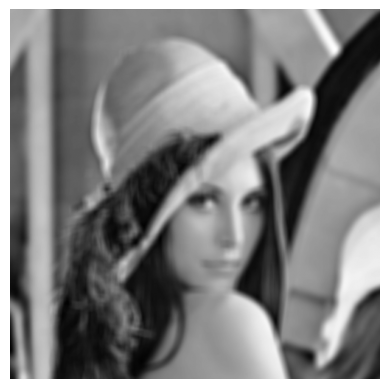

In [84]:
yar[:window_size-1, :] = compute_integral_image(image[:window_size-1, :])


for i in range(hei - window_size + 1):
    temp = compute_integral_image(image[i:, :])
    yar[i+window_size-1, :] = temp[window_size-1, :] 


final_result = np.zeros((hei-window_size+1,wei-window_size+1))
sub_size_hei,sub_size_wei = final_result.shape

for row in range(sub_size_hei):  # Iterate over each row in `yar`
    for col in range(sub_size_wei):  # Iterate over each column
            
            if col == 0:
                 final_result[row,col] = yar[row+window_size-1, window_size-1]
            else:
                final_result[row, col] = yar[row+window_size-1, col+window_size-1] - yar[row+window_size-1, col-1]

print("********** INTEGRAL IMAGE ALGO IN PYTHON ******************\n")           

normalized_img = normalize_and_display(final_result,window_size)




In [85]:
print(boxy[200:210,245])

print("\n *************")

print(filtered_image[200:210,245])


print("\n *************")

filtered_less = np.zeros((502,502))
filtered_less = filtered_image[5:507,5:507]
print(normalized_img[195:205,225])
print(filtered_less[195:205,225])

[9254. 9044. 8897. 8922. 9096. 8991. 8767. 8594. 8406. 8275.]

 *************
[76.47933884 74.74380165 73.52892562 73.73553719 75.17355372 74.30578512
 72.45454545 71.02479339 69.47107438 68.38842975]

 *************
[69 70 70 70 70 70 70 69 68 68]
[69.33057851 70.16528926 70.37190083 70.3553719  70.09090909 70.19834711
 70.         69.43801653 68.89256198 68.1322314 ]


In [53]:
row, col = 85, 85  # Pick any valid pixel in 502x502 range

# Corresponding pixel in boxy (original sum image)
boxy_pixel = boxy[row + 10, col + 10]

# Corresponding pixel in normalized image
normalized_pixel = normalized_img[100, 100]

print(f"Boxy[{row+5}, {col+5}] = {boxy_pixel}, Normalized[{row}, {col}] = {normalized_pixel}")




Boxy[90, 90] = 13755.0, Normalized[85, 85] = 105


In [54]:
for shift in range(1, 40):  # Testing ±2 pixels around expected shift
    print(f"Shift {shift}: Boxy[{row+shift}, {col+shift}] = {boxy[row+shift, col+shift]}")


Shift 1: Boxy[86, 86] = 13667.0
Shift 2: Boxy[87, 87] = 13704.0
Shift 3: Boxy[88, 88] = 13737.0
Shift 4: Boxy[89, 89] = 13761.0
Shift 5: Boxy[90, 90] = 13750.0
Shift 6: Boxy[91, 91] = 13783.0
Shift 7: Boxy[92, 92] = 13780.0
Shift 8: Boxy[93, 93] = 13745.0
Shift 9: Boxy[94, 94] = 13722.0
Shift 10: Boxy[95, 95] = 13755.0
Shift 11: Boxy[96, 96] = 13771.0
Shift 12: Boxy[97, 97] = 13812.0
Shift 13: Boxy[98, 98] = 13862.0
Shift 14: Boxy[99, 99] = 13894.0
Shift 15: Boxy[100, 100] = 13923.0
Shift 16: Boxy[101, 101] = 13958.0
Shift 17: Boxy[102, 102] = 14052.0
Shift 18: Boxy[103, 103] = 14127.0
Shift 19: Boxy[104, 104] = 14202.0
Shift 20: Boxy[105, 105] = 14299.0
Shift 21: Boxy[106, 106] = 14417.0
Shift 22: Boxy[107, 107] = 14570.0
Shift 23: Boxy[108, 108] = 14673.0
Shift 24: Boxy[109, 109] = 14762.0
Shift 25: Boxy[110, 110] = 14878.0
Shift 26: Boxy[111, 111] = 14971.0
Shift 27: Boxy[112, 112] = 15029.0
Shift 28: Boxy[113, 113] = 15044.0
Shift 29: Boxy[114, 114] = 15039.0
Shift 30: Boxy[115, 11

In [61]:
## normalized one is the one from FPGA algorithm. 
## filtered less is the equivalent of it :)

In [62]:
def fastGF (I,r,eps,s):

    I_sub = I
    r_sub = r

   ## (n1,n2) = I.shape

    (hei, wid) = I_sub.shape
    mx = np.ones((hei,wid))
    N = boxfilter(mx,r_sub)
    ########################
    mean_I = boxfilter(I_sub, r_sub) / N
    mean_II = boxfilter(I_sub*I_sub,r_sub) /N 

    cov_Ip = mean_II - mean_I * mean_I

    a   = cov_Ip / (cov_Ip + eps)
    b   = mean_I - a* mean_I
    
    mean_a = boxfilter(a, r_sub) / N
    mean_b = boxfilter(b, r_sub) / N

   ## mean_a = cv2.resize(mean_a, (n2, n1), interpolation=cv2.INTER_LINEAR)
   ## mean_b = cv2.resize(mean_b, (n2, n1), interpolation=cv2.INTER_LINEAR)


    q = mean_a * I + mean_b


    return q





In [66]:
filter_image = fastGF(image,12,0.25,1)

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

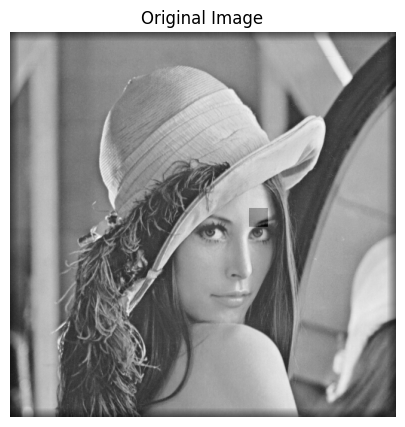

In [74]:
mean_I = boxfilter(image,12)

mean_II = boxfilter(image*image,12)


cov_Ip = mean_II - mean_I * mean_I

a   = cov_Ip / (cov_Ip + 1000)
b   = mean_I - a* mean_I
mean_a = boxfilter(a, 12)
mean_b = boxfilter(b, 12)

q = mean_a * image + mean_b


plt.figure(figsize=(10, 5))


plt.imshow(q, cmap='gray')
plt.title("Original Image")
plt.axis('off')


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

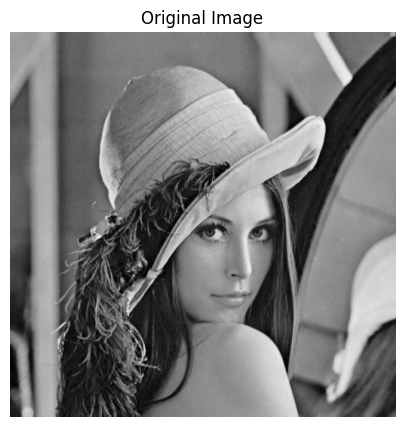

In [68]:

plt.figure(figsize=(10, 5))


plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')